# QoS Prediction Model Development

In [3]:
# =========================
# Bibliotecas
# =========================

# Manipulação de dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Estatística
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Pré-processamento e pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer

# Balanceamento
from sklearn.utils.class_weight import compute_class_weight

# Modelos
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Métricas
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    roc_curve, auc, confusion_matrix
)
from sklearn.preprocessing import label_binarize

# Interpretação
import shap

# Utilitários
import os
import json
import joblib

c:\Users\bbelissi\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load & inspect data

In [4]:
df = pd.read_csv("data/qws1.txt", delimiter=",", skiprows=42, on_bad_lines="skip")

print(df.head())


       45   83  27.2  50  97.4   89  91      43  58  100  1 DictionaryService  \
0   71.75  100  14.6  88  85.5   78  80   64.42  86   93  1         MyService   
1  117.00  100  23.4  83  88.0  100  87  111.00  59   90  1               aba   
2   70.00  100   5.4  83  79.3  100  75   63.00  91   90  1    AlexaWebSearch   
3  105.20  100  18.2  80  92.2   78  84  104.60  91   90  1       ErrorMailer   
4  224.00  100  24.6  83  80.0  100  87  223.00  88   90  1           getJoke   

  http://www.mindswap.org/2002/services/Dictionary.wsdl  
0          http://mydispatch.com/myservice.asmx?wsdl     
1  http://www.quentinsagerconsulting.com/wsdl/aba...     
2  http://wsearch.amazonaws.com/doc/2007-03-15/We...     
3  http://www.errormail.net/EM/ErrorMailer.asmx?wsdl     
4  http://www.interpressfact.net/webservices/getJ...     


Header creation

In [5]:

df.columns = [
    "ResponseTime", "Availability", "Throughput", "Successability",
    "Reliability", "Compliance", "BestPractices", "Latency", "Documentation",
    "WsRF", "Class", "ServiceName", "WSDLAddress"
]

print(df.head())


   ResponseTime  Availability  Throughput  Successability  Reliability  \
0         71.75           100        14.6              88         85.5   
1        117.00           100        23.4              83         88.0   
2         70.00           100         5.4              83         79.3   
3        105.20           100        18.2              80         92.2   
4        224.00           100        24.6              83         80.0   

   Compliance  BestPractices  Latency  Documentation  WsRF  Class  \
0          78             80    64.42             86    93      1   
1         100             87   111.00             59    90      1   
2         100             75    63.00             91    90      1   
3          78             84   104.60             91    90      1   
4         100             87   223.00             88    90      1   

      ServiceName                                        WSDLAddress  
0       MyService          http://mydispatch.com/myservice.asmx?wsdl 

### Data exploration

In [6]:
print(df.shape)    

(363, 13)


In [7]:
print(df.dtypes)

ResponseTime      float64
Availability        int64
Throughput        float64
Successability      int64
Reliability       float64
Compliance          int64
BestPractices       int64
Latency           float64
Documentation       int64
WsRF                int64
Class               int64
ServiceName        object
WSDLAddress        object
dtype: object


In [8]:
print(df.isnull().sum())

ResponseTime      0
Availability      0
Throughput        0
Successability    0
Reliability       0
Compliance        0
BestPractices     0
Latency           0
Documentation     0
WsRF              0
Class             0
ServiceName       0
WSDLAddress       0
dtype: int64


In [9]:
def is_duplicated(row):
    return row.duplicated().any()

duplicated_rows = df[df.duplicated()]
print(f"Number of duplicate rows: {len(duplicated_rows)}")

Number of duplicate rows: 0


### Distribution

In [10]:
print(df.describe())

       ResponseTime  Availability  Throughput  Successability  Reliability  \
count    363.000000    363.000000  363.000000      363.000000   363.000000   
mean     842.473893     84.757576    7.230028       64.476584    61.220110   
std     2767.816565     20.479519    6.381522       21.188483    21.144046   
min       50.000000     14.000000    0.100000        7.000000     5.900000   
25%      137.505000     74.500000    2.150000       50.000000    49.800000   
50%      237.000000     96.000000    5.600000       67.000000    64.100000   
75%      481.125000    100.000000   10.600000       80.500000    77.950000   
max    30781.000000    100.000000   29.500000       99.000000    97.700000   

       Compliance  BestPractices       Latency  Documentation        WsRF  \
count  363.000000     363.000000    363.000000     363.000000  363.000000   
mean    83.663912      80.661157    765.464843      47.501377   66.561983   
std      8.779213       6.678348   2759.100577      36.446690   11

Histogram

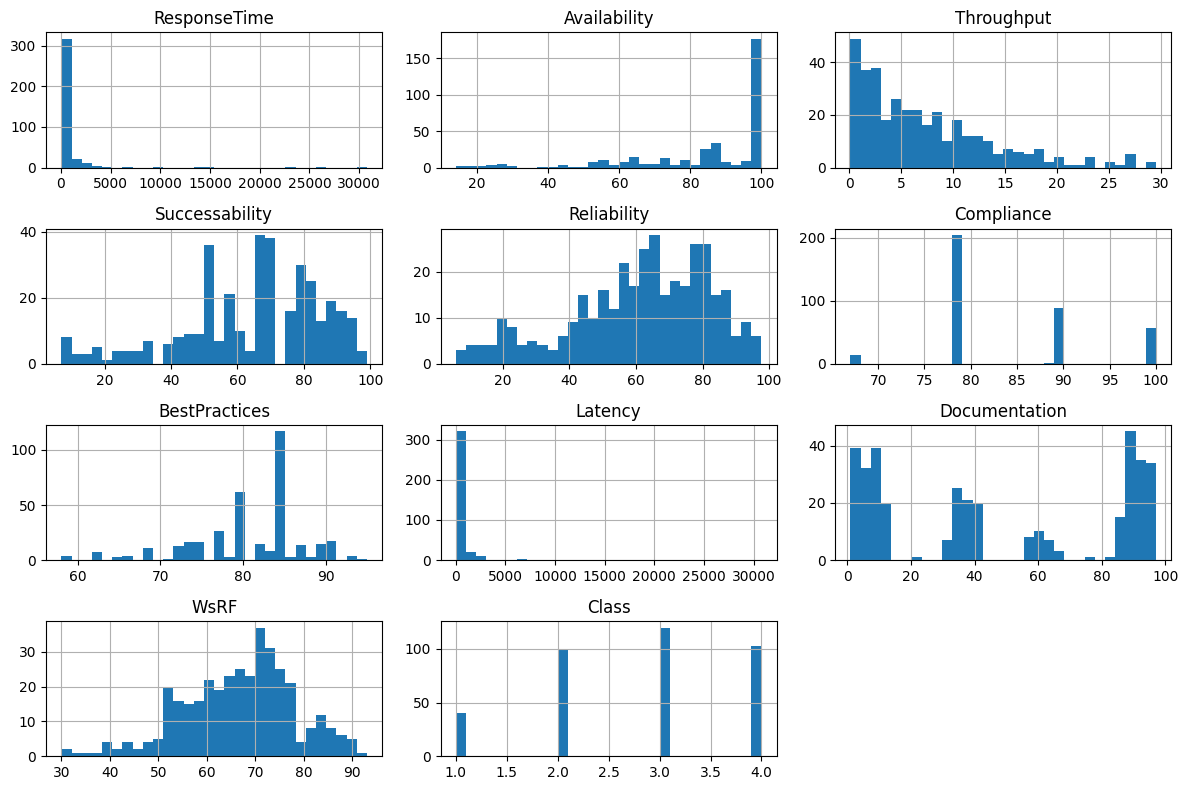

In [11]:
df.hist(figsize=(12,8), bins=30)
plt.tight_layout()
plt.show()

Conclusões:
1) ResponseTime e Latency apresentam forte skew e outliers (valores até ~30.000).
2) Variáveis de qualidade (Availability, Successability, etc.) concentradas entre 70–100.
3) Dataset desbalanceado (Classe 1 bem menor).

### Correlation

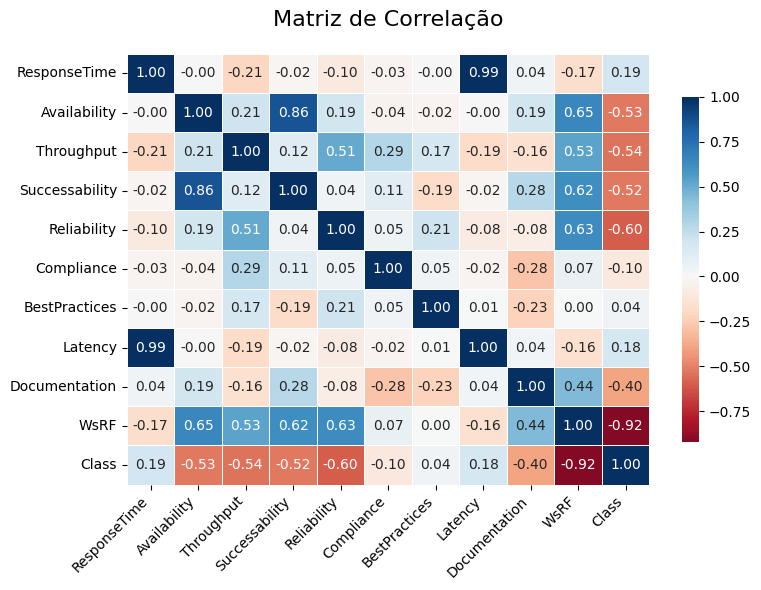

In [12]:
# Calcula a correlação
corr = df.iloc[:, :11].corr()

# Define tamanho da figura
plt.figure(figsize=(8, 6))

# Cria o heatmap com melhorias
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",           
    cmap="RdBu",         
    center=0,           
    linewidths=0.5,     
    cbar_kws={"shrink": 0.8}  
)

# Ajusta título e rótulos
plt.title("Matriz de Correlação", fontsize=16, pad=20)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout()
plt.show()


Correlação com o Target

C:\Users\bbelissi\AppData\Local\Temp\ipykernel_13596\756012136.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_target.values, y=corr_target.index, palette="coolwarm")


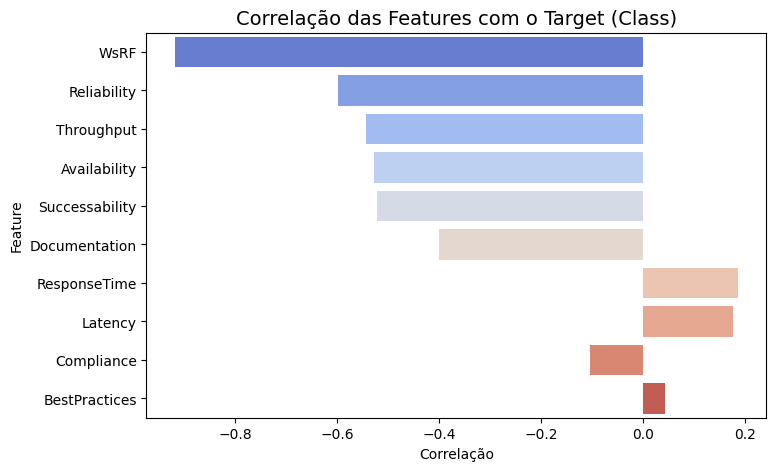

WsRF             -0.919156
Reliability      -0.599183
Throughput       -0.542713
Availability     -0.526910
Successability   -0.522154
Documentation    -0.400689
ResponseTime      0.186878
Latency           0.175783
Compliance       -0.104140
BestPractices     0.042653
Name: Class, dtype: float64


In [13]:

# Seleciona apenas colunas numéricas
numeric_df = df.select_dtypes(include=['number'])

# Calcula correlação com o target
corr_target = numeric_df.corr()['Class'].drop('Class').sort_values(key=abs, ascending=False)

# Gráfico
plt.figure(figsize=(8,5))
sns.barplot(x=corr_target.values, y=corr_target.index, palette="coolwarm")
plt.title("Correlação das Features com o Target (Class)", fontsize=14)
plt.xlabel("Correlação")
plt.ylabel("Feature")
plt.show()

# Exibe valores
print(corr_target)

Conclusão:
1) WsRF: -0.92 (mais relevante)
2) ResponseTime e Latency: correlação fraca com target (+0.18), mas alta entre si (0.99).

### Multicolinearidade (VIF)

In [14]:
# Seleciona apenas colunas numéricas (sem o target)
X = df.select_dtypes(include=['number']).drop(columns=['Class'])

# Adiciona constante
X_const = add_constant(X)

# Calcula VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X_const.values, i+1) for i in range(len(X.columns))]

# Ordena por VIF
print(vif_data.sort_values(by='VIF', ascending=False))

          Feature        VIF
0    ResponseTime  88.329539
7         Latency  87.067695
9            WsRF  16.189688
3  Successability   7.197066
1    Availability   5.506404
4     Reliability   5.121994
8   Documentation   4.275823
2      Throughput   2.596770
5      Compliance   1.476190
6   BestPractices   1.198003


Decisão: remover uma entre ResponseTime e Latency ou aplicar PCA.

### Conclusão final

Tomar alguma decisão para o pré-processamento:

1) Aplicar log-transform em ResponseTime para reduzir skew.
2) Remover Latency (ou usar PCA).
3) Normalizar todas as features numéricas.
4) Usar split estratificado no Passo 3.

## Split data

In [15]:
# Features e target
X = df.drop(columns=['Class'])
y = df['Class']


In [16]:
# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Treino:", X_train.shape, "Teste:", X_test.shape)
print("Distribuição treino:", y_train.value_counts(normalize=True))
print("Distribuição teste:", y_test.value_counts(normalize=True))

Treino: (290, 12) Teste: (73, 12)
Distribuição treino: Class
3    0.331034
4    0.282759
2    0.275862
1    0.110345
Name: proportion, dtype: float64
Distribuição teste: Class
3    0.328767
4    0.287671
2    0.273973
1    0.109589
Name: proportion, dtype: float64


## Preprocess

In [17]:
# 1. Remove a coluna 'Latency'
X_train = X_train.drop(columns=['Latency'])
X_test = X_test.drop(columns=['Latency'])

In [18]:
# Remove colunas categóricas irrelevantes
cols_to_drop = ['ServiceName', 'WSDLAddress']
X_train = X_train.drop(columns=cols_to_drop)
X_test = X_test.drop(columns=cols_to_drop)

In [19]:
X_train = X_train.drop(columns=['WsRF'])
X_test = X_test.drop(columns=['WsRF'])

In [20]:
# 2. Identificar colunas numéricas
numeric_features = X_train.select_dtypes(include=['number']).columns.tolist()

In [21]:
# Função para aplicar log-transform em ResponseTime
def log_transform(X):
    X = X.copy()
    if 'ResponseTime' in X.columns:
        X['ResponseTime'] = np.log1p(X['ResponseTime'])
    return X

log_transformer = FunctionTransformer(log_transform)

In [22]:
# Pré-processamento para numéricas
numeric_transformer = Pipeline(steps=[
    ('log', log_transformer),  # aplica log-transform em ResponseTime
    ('imputer', SimpleImputer(strategy='median')),  # caso haja nulos
])

In [23]:

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, X_train.select_dtypes(include=['number']).columns.tolist())
    ]
)


In [24]:
# Ajusta o pré-processador nos dados de treino
preprocessor.fit(X_train)

# Transforma os dados
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

print("Shape após pré-processamento:")
print("Treino:", X_train_preprocessed.shape)
print("Teste:", X_test_preprocessed.shape)

Shape após pré-processamento:
Treino: (290, 8)
Teste: (73, 8)


## Baseline

In [25]:
# Baseline: sempre prevê a classe mais frequente
baseline = DummyClassifier(strategy='stratified', random_state=42)
baseline.fit(X_train_preprocessed, y_train)

# Predições
y_pred_baseline = baseline.predict(X_test_preprocessed)
y_proba_baseline = baseline.predict_proba(X_test_preprocessed)

# Métricas
accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
f1_baseline = f1_score(y_test, y_pred_baseline, average='macro')
roc_auc_baseline = roc_auc_score(y_test, y_proba_baseline, multi_class='ovr', average='macro')

print("Baseline Results:")
print(f"Accuracy: {accuracy_baseline:.4f}")
print(f"F1 (macro): {f1_baseline:.4f}")
print(f"ROC AUC (macro): {roc_auc_baseline:.4f}")

Baseline Results:
Accuracy: 0.2877
F1 (macro): 0.2428
ROC AUC (macro): 0.4970


## Train models

### Random Forest

In [26]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train_preprocessed, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [27]:
y_pred_rf = rf.predict(X_test_preprocessed)
y_proba_rf = rf.predict_proba(X_test_preprocessed)

In [28]:
print("=== Random Forest ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("F1:", f1_score(y_test, y_pred_rf, average='macro'))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf, multi_class='ovr', average='macro'))

=== Random Forest ===
Accuracy: 0.7123287671232876
F1: 0.7519182657349552
ROC AUC: 0.9095771563342319


### XGBoost

In [29]:

# Ajuste das classes para começar em 0
y_train_adj = y_train - 1
y_test_adj = y_test - 1


In [30]:

# Calcula pesos para cada classe
classes = np.unique(y_train_adj)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_adj)
class_weights_dict = dict(zip(classes, weights))
print("Pesos por classe:", class_weights_dict)

Pesos por classe: {np.int64(0): np.float64(2.265625), np.int64(1): np.float64(0.90625), np.int64(2): np.float64(0.7552083333333334), np.int64(3): np.float64(0.8841463414634146)}


In [31]:
# Cria vetor de pesos para cada amostra
sample_weights = np.array([class_weights_dict[c] for c in y_train_adj])


In [32]:

# Modelo XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)


In [33]:

xgb.fit(X_train_preprocessed, y_train_adj, sample_weight=sample_weights)


c:\Users\bbelissi\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:30:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [34]:
# Avaliação
y_pred_xgb = xgb.predict(X_test_preprocessed)
y_proba_xgb = xgb.predict_proba(X_test_preprocessed)

accuracy_xgb = accuracy_score(y_test_adj, y_pred_xgb)
f1_xgb = f1_score(y_test_adj, y_pred_xgb, average='macro')
roc_auc_xgb = roc_auc_score(y_test_adj, y_proba_xgb, multi_class='ovr', average='macro')

print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"F1 (macro): {f1_xgb:.4f}")
print(f"ROC AUC (macro): {roc_auc_xgb:.4f}")


Accuracy: 0.7260
F1 (macro): 0.7407
ROC AUC (macro): 0.8962


## Tune

### Random Forest

In [35]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import numpy as np


param_dist = {
    'n_estimators': np.arange(100, 1001, 100),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,               
    scoring='f1_macro',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Modelo base com balanceamento
rf = RandomForestClassifier(random_state=42, class_weight='balanced')


# Ajuste
random_search.fit(X_train_preprocessed, y_train)

# Melhores parâmetros
print("Melhores parâmetros:", random_search.best_params_)

# Modelo final
best_rf = random_search.best_estimator_

# Avaliação
y_pred_best_rf = best_rf.predict(X_test_preprocessed)
y_proba_best_rf = best_rf.predict_proba(X_test_preprocessed)

accuracy_best = accuracy_score(y_test, y_pred_best_rf)
f1_best = f1_score(y_test, y_pred_best_rf, average='macro')
roc_auc_best = roc_auc_score(y_test, y_proba_best_rf, multi_class='ovr', average='macro')

print(f"Accuracy: {accuracy_best:.4f}")
print(f"F1 (macro): {f1_best:.4f}")
print(f"ROC AUC (macro): {roc_auc_best:.4f}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Melhores parâmetros: {'n_estimators': np.int64(1000), 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}
Accuracy: 0.6438
F1 (macro): 0.6755
ROC AUC (macro): 0.9102


### XGBoost

In [36]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import numpy as np

# Espaço de busca para XGBoost
param_dist_xgb = {
    'n_estimators': np.arange(100, 1001, 100),
    'max_depth': [3, 5, 7, 10],
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

# Modelo base
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

# RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist_xgb,
    n_iter=50,                # número de combinações aleatórias
    scoring='f1_macro',       # métrica principal
    cv=5,                     # validação cruzada
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Ajuste nos dados pré-processados
random_search_xgb.fit(X_train_preprocessed, y_train_adj, sample_weight=sample_weights)

# Melhores parâmetros
print("Melhores parâmetros XGBoost:", random_search_xgb.best_params_)

# Modelo final com melhores parâmetros
best_xgb = random_search_xgb.best_estimator_

# Avaliação no conjunto de teste
y_pred_best_xgb = best_xgb.predict(X_test_preprocessed)
y_proba_best_xgb = best_xgb.predict_proba(X_test_preprocessed)

accuracy_xgb = accuracy_score(y_test_adj, y_pred_best_xgb)
f1_xgb = f1_score(y_test_adj, y_pred_best_xgb, average='macro')
roc_auc_xgb = roc_auc_score(y_test_adj, y_proba_best_xgb, multi_class='ovr', average='macro')

print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"F1 (macro): {f1_xgb:.4f}")
print(f"ROC AUC (macro): {roc_auc_xgb:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits


Melhores parâmetros XGBoost: {'subsample': 0.6, 'reg_lambda': 2, 'reg_alpha': 0.01, 'n_estimators': np.int64(100), 'max_depth': 3, 'learning_rate': np.float64(0.20333333333333334), 'gamma': 0, 'colsample_bytree': 1.0}
Accuracy: 0.7397
F1 (macro): 0.7630
ROC AUC (macro): 0.9202


c:\Users\bbelissi\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:31:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## Evaluate

In [37]:
def evaluate_model(name, y_true, y_pred, y_proba, cmap='Blues'):
    # Métricas principais
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    roc_auc = roc_auc_score(y_true, y_proba, multi_class='ovr', average='macro')
    
    print(f"\n=== {name} ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 (macro): {f1:.4f}")
    print(f"ROC AUC (macro): {roc_auc:.4f}")
    
    # Matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
    # Curva ROC para multi-class
    classes = np.unique(y_true)
    y_true_bin = label_binarize(y_true, classes=classes)
    plt.figure(figsize=(8, 6))
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
        plt.plot(fpr, tpr, label=f'Class {cls} (AUC = {auc(fpr, tpr):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name} (Multi-class)')
    plt.legend()
    plt.show()


=== Random Forest ===
Accuracy: 0.7123
F1 (macro): 0.7519
ROC AUC (macro): 0.9096


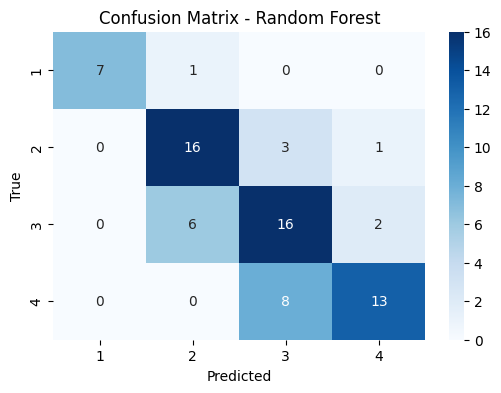

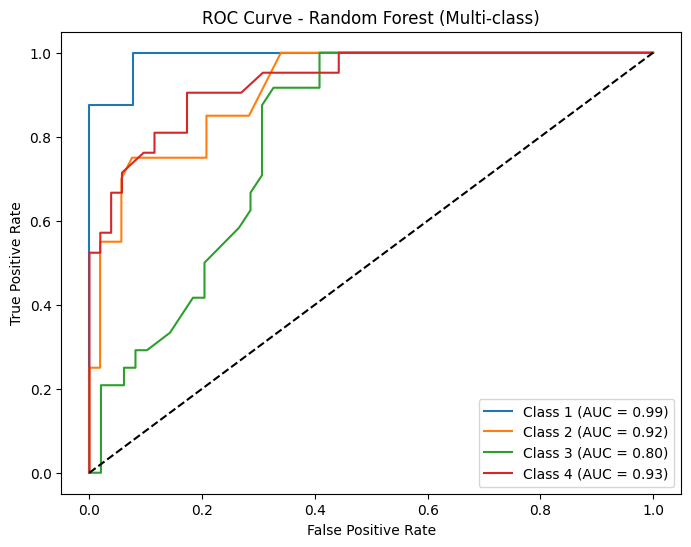


=== Random Forest Tuned ===
Accuracy: 0.6438
F1 (macro): 0.6755
ROC AUC (macro): 0.9102


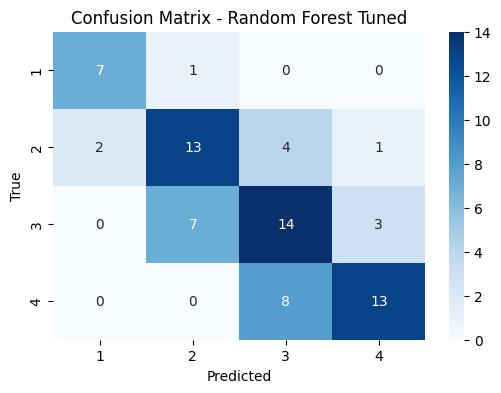

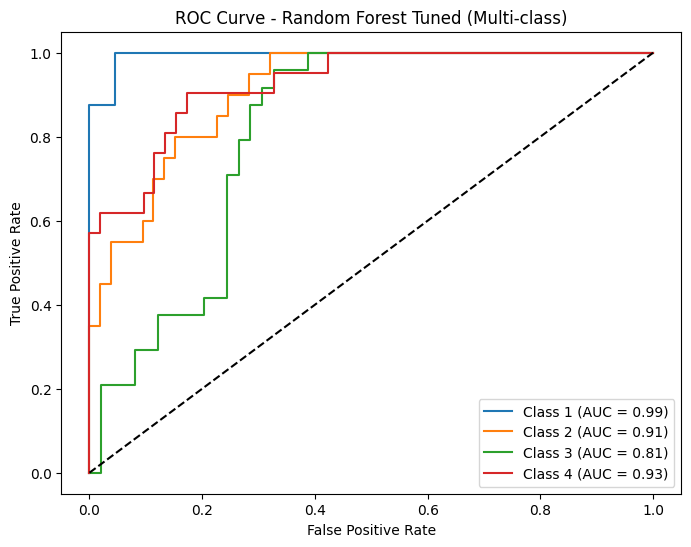


=== XGBoost ===
Accuracy: 0.7260
F1 (macro): 0.7407
ROC AUC (macro): 0.8962


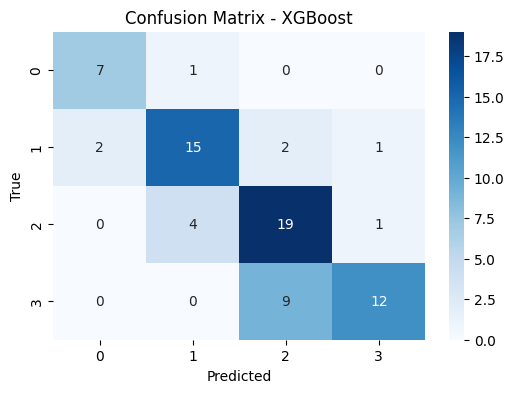

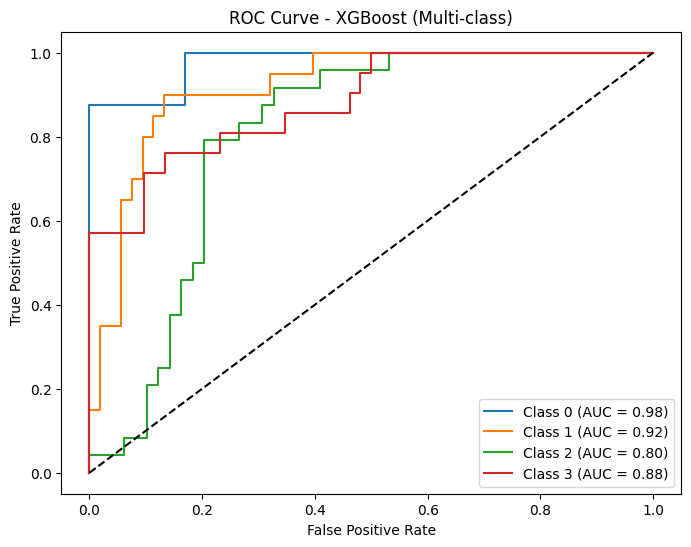


=== XGBoost Tuned ===
Accuracy: 0.7397
F1 (macro): 0.7630
ROC AUC (macro): 0.9202


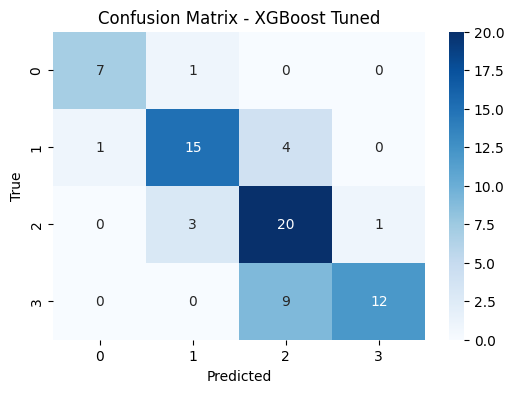

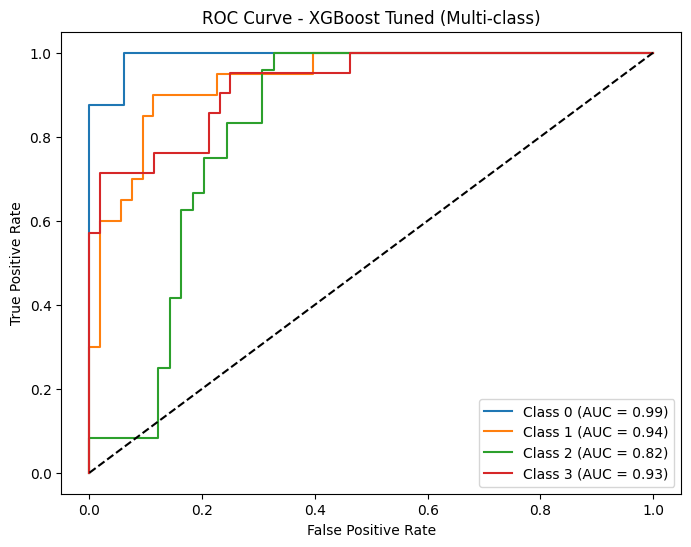

In [38]:

evaluate_model("Random Forest", y_test, y_pred_rf, y_proba_rf)
evaluate_model("Random Forest Tuned", y_test, y_pred_best_rf, y_proba_best_rf)
evaluate_model("XGBoost", y_test_adj, y_pred_xgb, y_proba_xgb)
evaluate_model("XGBoost Tuned", y_test_adj, y_pred_best_xgb, y_proba_best_xgb)

## Feature Importance

### Random Forest

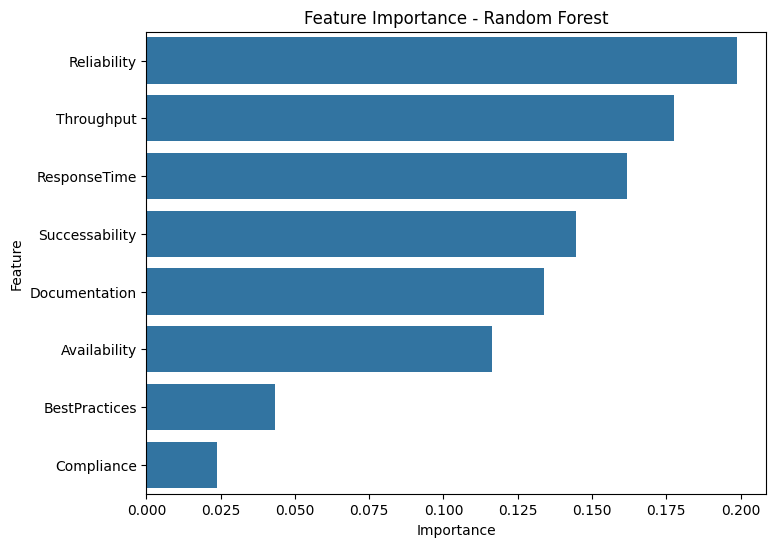

In [39]:
# Importâncias do modelo Random Forest
rf_importances = best_rf.feature_importances_
rf_features = X_train.select_dtypes(include=['number']).columns.tolist()

# DataFrame ordenado
rf_df = pd.DataFrame({'Feature': rf_features, 'Importance': rf_importances})
rf_df = rf_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=rf_df)
plt.title('Feature Importance - Random Forest')
plt.show()


### XGBoost

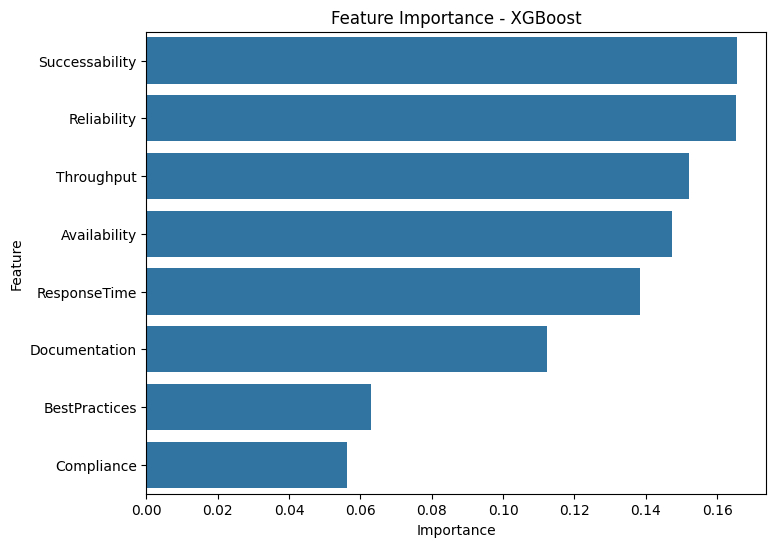

In [40]:
# Importâncias do modelo XGBoost
xgb_importances = best_xgb.feature_importances_
xgb_features = X_train.select_dtypes(include=['number']).columns.tolist()

# DataFrame ordenado
xgb_df = pd.DataFrame({'Feature': xgb_features, 'Importance': xgb_importances})
xgb_df = xgb_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=xgb_df)
plt.title('Feature Importance - XGBoost')
plt.show()

## SHAP

### Random Forest

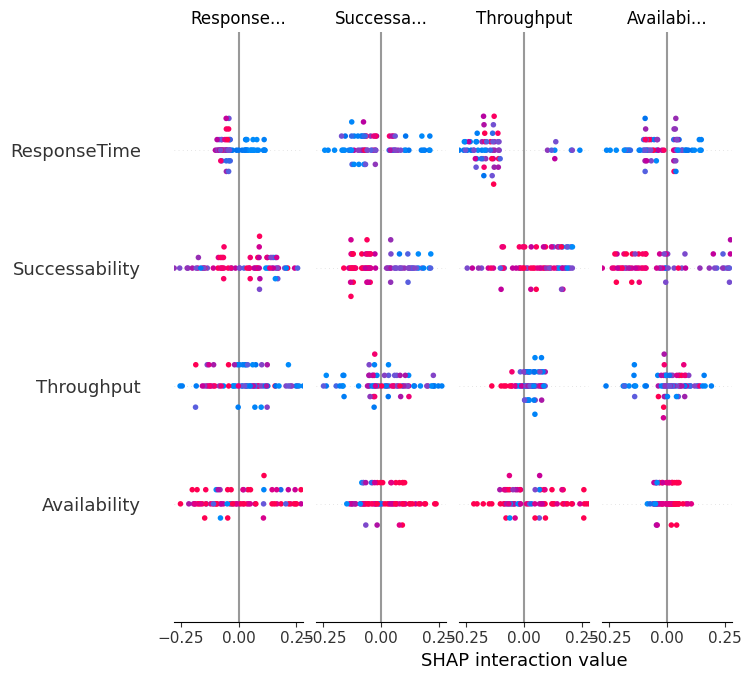

In [41]:
# Cria o explainer para Random Forest
explainer_rf = shap.TreeExplainer(best_rf)
shap_values_rf = explainer_rf.shap_values(X_test_preprocessed)

# Summary plot (importância global)
shap.summary_plot(shap_values_rf, X_test_preprocessed, feature_names=X_train.select_dtypes(include=['number']).columns.tolist())

### XGBoost

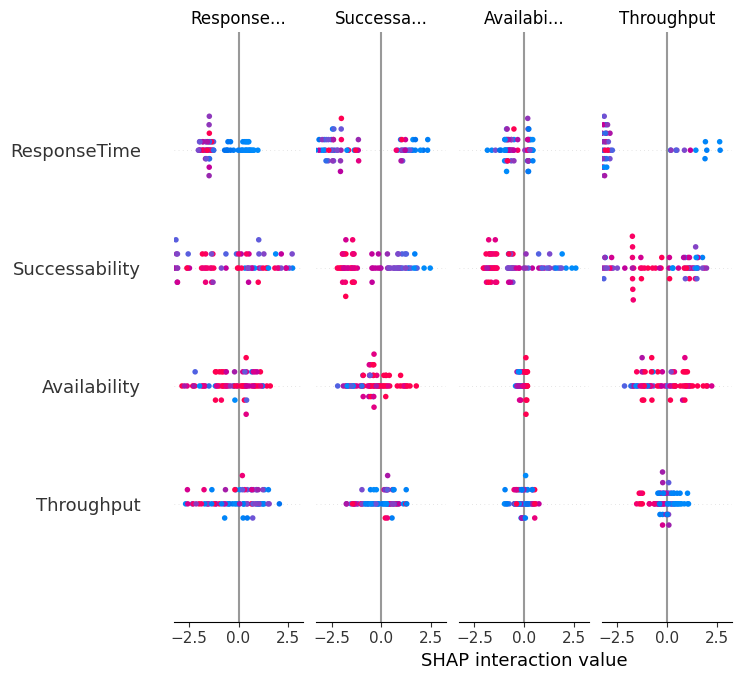

In [42]:
# Cria o explainer para XGBoost
explainer_xgb = shap.TreeExplainer(best_xgb)
shap_values_xgb = explainer_xgb.shap_values(X_test_preprocessed)

# Summary plot
shap.summary_plot(shap_values_xgb, X_test_preprocessed, feature_names=X_train.select_dtypes(include=['number']).columns.tolist())

## Model Card

In [43]:
import os
import joblib
import json
import pandas as pd

def save_model_package(base_path, task_type, model_name, model, metrics, feature_names, data_info,
                       X_train=None, X_test=None, y_train=None, y_test=None,
                       X_train_preprocessed=None, X_test_preprocessed=None):
    """
    Salva pacote completo do modelo, incluindo:
    - Modelo treinado
    - Métricas (JSON + CSV)
    - Model Card
    - Splits originais e preprocessados (opcional)
    """
    path = os.path.join(base_path, task_type, model_name)
    os.makedirs(path, exist_ok=True)

    # Salva modelo
    joblib.dump(model, os.path.join(path, 'model.pkl'))

    # Salva métricas
    with open(os.path.join(path, 'metrics.json'), 'w') as f:
        json.dump(metrics, f, indent=4)
    pd.DataFrame([metrics]).to_csv(os.path.join(path, 'metrics.csv'), index=False)

    # Cria model card
    with open(os.path.join(path, 'model_card.md'), 'w') as f:
        f.write(f"""
# Model Card: {model_name.capitalize()}

## Task
{task_type.capitalize()}

## Data
Fonte: {data_info.get('source')}
Período: {data_info.get('period')}
Tamanho: {data_info.get('size')}

## Features
{', '.join(feature_names)}

## Metrics
{json.dumps(metrics, indent=4)}

## Limitations
- Dados limitados ao contexto do Route 25
- Sensível a escalonamento

## Ethical Considerations
- Não inclui variáveis sensíveis (raça, gênero)
""")

    # Salva splits originais (se fornecidos)
    if X_train is not None and X_test is not None:
        joblib.dump(X_train, os.path.join(path, 'X_train.pkl'))
        joblib.dump(X_test, os.path.join(path, 'X_test.pkl'))
    if y_train is not None and y_test is not None:
        joblib.dump(y_train, os.path.join(path, 'y_train.pkl'))
        joblib.dump(y_test, os.path.join(path, 'y_test.pkl'))

    # Salva dados preprocessados (se fornecidos)
    if X_train_preprocessed is not None and X_test_preprocessed is not None:
        joblib.dump(X_train_preprocessed, os.path.join(path, 'X_train_preprocessed.pkl'))
        joblib.dump(X_test_preprocessed, os.path.join(path, 'X_test_preprocessed.pkl'))

    print(f"Pacote do modelo salvo em: {path}")

In [44]:
# Informações do dataset
data_info = {
    "source": "Dados internos Route 25",
    "period": "2025",
    "size": "Volume interno"
}

feature_names = X_train.select_dtypes(include=['number']).columns.tolist()

# Baseline
save_model_package('model_package', 'classification', 'baseline', baseline,
                   {"Accuracy": accuracy_baseline, "F1": f1_baseline, "ROC_AUC": roc_auc_baseline},
                   feature_names, data_info,
                   X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test,
                   X_train_preprocessed=X_train_preprocessed, X_test_preprocessed=X_test_preprocessed)

# Random Forest
save_model_package('model_package', 'classification', 'random_forest', best_rf,
                   {"Accuracy": accuracy_best, "F1": f1_best, "ROC_AUC": roc_auc_best},
                   feature_names, data_info,
                   X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test,
                   X_train_preprocessed=X_train_preprocessed, X_test_preprocessed=X_test_preprocessed
                   )

# XGBoost
save_model_package('model_package', 'classification', 'xgboost', best_xgb,
                   {"Accuracy": accuracy_xgb, "F1": f1_xgb, "ROC_AUC": roc_auc_xgb},
                   feature_names, data_info,
                   X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test,
                   X_train_preprocessed=X_train_preprocessed, X_test_preprocessed=X_test_preprocessed
                   )


Pacote do modelo salvo em: model_package\classification\baseline
Pacote do modelo salvo em: model_package\classification\random_forest
Pacote do modelo salvo em: model_package\classification\xgboost
